## First benchmark

To benchmark: estimating disassembly indexes for increasing levels of complex peptidomes


        

In [1]:
from disassembly.simulate_proteolysis import enzyme_set, enzyme, amino_acids


enzymes1 = enzyme_set(
    [
        enzyme({"K": 1}, "K protease"),
    ],
    [1],
    [1],
)

enzymes2 = enzyme_set(
    [
        enzyme({"K": 0.5, "R": 0.5}, "K+R protease"),
    ],
    [1],
    [1],
)


enzymes3 = enzyme_set(
    [
        enzyme({"V": 0.35, "I": 0.25, "A": 0.2, "T": 0.1}, "V+I+A+T protease"),
    ],
    [1],
    [1],
)

random = enzyme_set(
    [enzyme({aa: 1 / len(amino_acids) for aa in amino_acids.values()}, "random")],
    [1],
    [1],
)

In [2]:
protein = "MKAAVLTLAVLFLTGSQARHFWQQDEPPQSPWDRVKDLATVYVDVLKDSGRDYVSQFEGSALGKQLNLKLLDNWDSVTSTFSKLREQLGPVTQEFWDNLEKETEGLRQEMSKDLEEVKAKVQPYLDDFQKKWQEEMELYRQKVEPLRAELQEGARQKLHELQEKLSPLGEEMRDRARAHVDALRTHLAPYSDELRQRLAARLEALKENGGARLAEYHAKATEHLSTLSEKAKPALEDLRQGLLPVLESFKVSFLSALEEYTKKLNTQ"

In [3]:
from disassembly.benchmark import Benchmark

bmrk = Benchmark()

enzyme_sets = [random]
enzyme_names = ["random"]

bmrk.simulate_degradation(
    protein,
    enzyme_sets=enzyme_sets,
    enzyme_names=enzyme_names,
    n_generate=1000,
    endo_or_exo_probability=[0.9, 0.1],
    iterations=5,
)

Running random, 0
 103 / 1000 (113)

/Users/erikhartman/dev/disassembly/src/disassembly/simulate_proteolysis.py:218: RuntimeWarning: invalid value encountered in scalar divide
  p / sum(index_to_cut.values()) for p in index_to_cut.values()


 999 / 1000 (1141)
917 unique peptides. 1003 total

 Averaged DI: 2.34
Running random, 1
 999 / 1000 (1124)
931 unique peptides. 1003 total

 Averaged DI: 2.40
Running random, 2
 999 / 1000 (1129)
915 unique peptides. 1003 total

 Averaged DI: 2.34
Running random, 3
 999 / 1000 (1154)
922 unique peptides. 1003 total

 Averaged DI: 2.42
Running random, 4
 999 / 1000 (1103)
918 unique peptides. 1003 total

 Averaged DI: 2.38


--random---
 0 / 500 | 1.46, mean: nan | Plateau | nz: 0

/Users/erikhartman/dev/disassembly/.venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/erikhartman/dev/disassembly/.venv/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/erikhartman/dev/disassembly/.venv/lib/python3.9/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/erikhartman/dev/disassembly/.venv/lib/python3.9/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/erikhartman/dev/disassembly/.venv/lib/python3.9/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


 199 / 500 | 0.04, mean: 0.05 | Plateau | nz: 8490500
Learning rate decreased to 0.5
 223 / 500 | 0.03, mean: 0.04 | Plateau | nz: 8666
 Averaged DI: 4.07
 202 / 500 | 0.05, mean: 0.06 | Plateau | nz: 8192143
Learning rate decreased to 0.5
 226 / 500 | 0.04, mean: 0.04 | Plateau | nz: 8182
 Averaged DI: 4.16
 195 / 500 | 0.04, mean: 0.05 | Plateau | nz: 7958975
Learning rate decreased to 0.5
 218 / 500 | 0.04, mean: 0.04 | Plateau | nz: 7923
 Averaged DI: 3.91
 201 / 500 | 0.04, mean: 0.06 | Plateau | nz: 85285475
Learning rate decreased to 0.5
 225 / 500 | 0.04, mean: 0.04 | Plateau | nz: 8517
 Averaged DI: 4.16
 204 / 500 | 0.04, mean: 0.05 | Plateau | nz: 86586737
Learning rate decreased to 0.5
 227 / 500 | 0.04, mean: 0.04 | Plateau | nz: 8715
 Averaged DI: 4.19


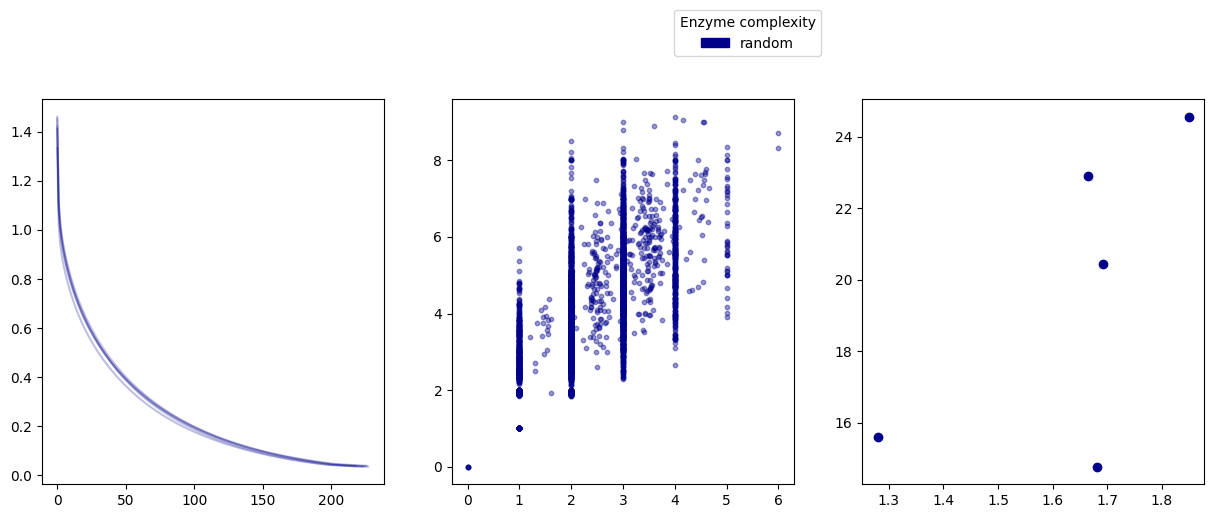

In [4]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

bmrk.estimate_weights(method="alg", n_iterations=500, lr=1)

bmrk.plot(axs[0], ptype="loss", method_name="alg")
bmrk.plot(axs[1], ptype="corr_di", method_name="alg")
bmrk.plot(axs[2], ptype="d", method_name="alg")

In [5]:
bmrk.estimate_weights(method="gd", n_iterations=200)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

bmrk.plot(ax=axs[0], ptype="loss", method_name="gd")
bmrk.plot(ax=axs[1], ptype="corr_di", method_name="gd")
bmrk.plot(ax=axs[2], ptype="d", method_name="gd")

--random---
 199 / 200 | 0.14, kl: 0.14, reg: 0.00  | nz: 7842 | 
 Averaged DI: 3.31
 199 / 200 | 0.13, kl: 0.13, reg: 0.00  | nz: 7615 | 
 Averaged DI: 3.42
 199 / 200 | 0.14, kl: 0.14, reg: 0.00  | nz: 7789 | 
 Averaged DI: 3.31
 17 / 200 | 0.61, kl: 0.61, reg: 0.00  | nz: 10909 | 

KeyboardInterrupt: 

In [6]:
bmrk.estimate_weights(method="gd", lam1=0.1, n_iterations=200, method_name="gd_l1")

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

bmrk.plot(ax=axs[0], ptype="loss", method_name="gd_l1")
bmrk.plot(ax=axs[1], ptype="corr_di", method_name="gd_l1")
bmrk.plot(ax=axs[2], ptype="d", method_name="gd_l1")

--random---
 40 / 200 | 4.76, kl: 0.01, reg: 4.74  | nz: 228 | | | 

KeyboardInterrupt: 

--simple---
 199 / 200 | 0.43, kl: 0.03, reg: 0.40  | nz: 203 | 
 Averaged DI: 2.28
 199 / 200 | 0.51, kl: 0.04, reg: 0.47  | nz: 188 | 
 Averaged DI: 2.29
 199 / 200 | 0.59, kl: 0.03, reg: 0.56  | nz: 236 | 
 Averaged DI: 2.14
 199 / 200 | 0.68, kl: 0.04, reg: 0.64  | nz: 243 | 
 Averaged DI: 2.25
 199 / 200 | 0.49, kl: 0.02, reg: 0.46  | nz: 222 | 
 Averaged DI: 2.28
--complex---
 199 / 200 | 0.70, kl: 0.01, reg: 0.70  | nz: 683 | 
 Averaged DI: 2.46
 199 / 200 | 0.78, kl: 0.01, reg: 0.77  | nz: 603 | 
 Averaged DI: 2.55
 199 / 200 | 0.86, kl: 0.01, reg: 0.86  | nz: 621 | 
 Averaged DI: 2.59
 199 / 200 | 0.72, kl: 0.01, reg: 0.72  | nz: 625 | 
 Averaged DI: 2.54
 199 / 200 | 0.71, kl: 0.01, reg: 0.70  | nz: 671 | 
 Averaged DI: 2.60
--random---
 199 / 200 | 0.73, kl: 0.01, reg: 0.73  | nz: 551 | 
 Averaged DI: 2.48
 199 / 200 | 0.56, kl: 0.01, reg: 0.56  | nz: 490 | 
 Averaged DI: 2.48
 199 / 200 | 0.45, kl: 0.01, reg: 0.44  | nz: 425 | 
 Averaged DI: 2.62
 199 / 200 | 0.54, kl: 0.00

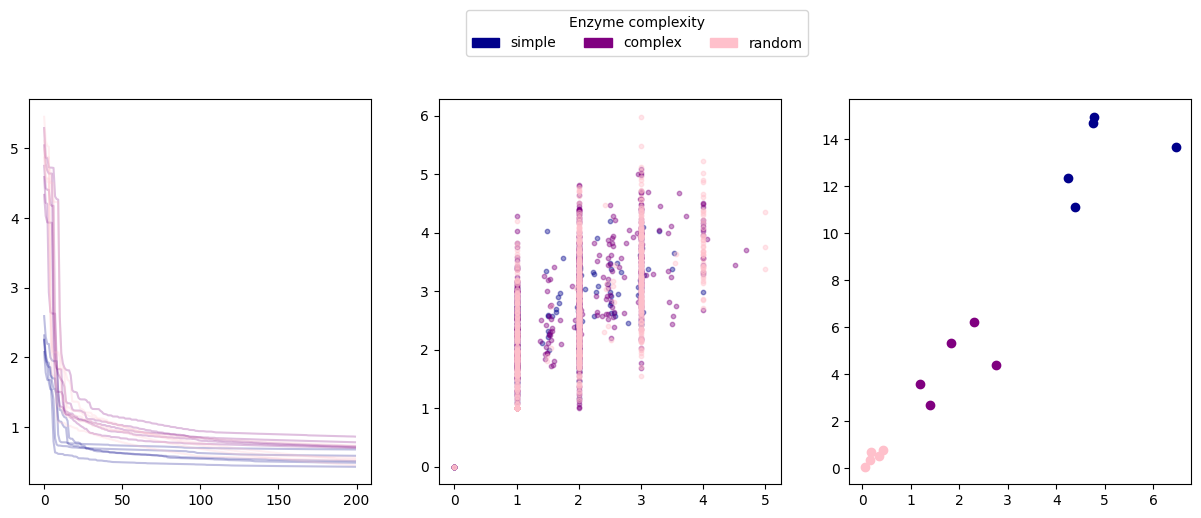

In [ ]:
bmrk.estimate_weights(method="gd", lam2=0.1, n_iterations=200, method_name="gd_l2")

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

bmrk.plot(ax=axs[0], ptype="loss", method_name="gd_l2")
bmrk.plot(ax=axs[1], ptype="corr_di", method_name="gd_l2")
bmrk.plot(ax=axs[2], ptype="d", method_name="gd_l2")

In [ ]:
bmrk.estimate_weights(
    method="gd",
    n_iterations=200,
    lam1=0.1,
    lam2=0.1,
    parameter_estimator=True,
    method_name="gd_param",
)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

bmrk.plot(ax=axs[0], ptype="loss", method_name="gd_param")
bmrk.plot(ax=axs[1], ptype="corr_di", method_name="gd_param")
bmrk.plot(ax=axs[2], ptype="d", method_name="gd_param")

--simple---
Iteration: 0
	V: 27.22 | 27.54
V better!
	V: 27.57 | 27.22
	I: 27.16 | 27.22
I better!
	I: 27.18 | 27.16
	L: 26.91 | 27.16
L better!
	L: 27.60 | 26.91
	E: 27.57 | 26.91
	Q: 26.61 | 26.91
Q better!
	Q: 27.25 | 26.61
	D: 26.69 | 26.61
	N: 27.10 | 26.61
	H: 27.57 | 26.61
	W: 27.53 | 26.61
	F: 25.83 | 26.61
F better!
	F: 27.62 | 25.83
	Y: 27.64 | 25.83
	R: 27.55 | 25.83
	K: 22.64 | 25.83
K better!
	K: 18.16 | 22.64
K better!
	K: 18.95 | 18.16
	S: 22.61 | 18.16
	T: 20.91 | 18.16
	M: 18.29 | 18.16
	A: 21.36 | 18.16
	G: 24.70 | 18.16
	P: 17.82 | 18.16
P better!
	P: 19.04 | 17.82
	C: 17.65 | 17.82
C better!
	C: 17.75 | 17.65
 exo: 16.58 | 16.58 (0.25)
 exo: 18.45 | 16.58 (0.25)
 exo: 19.81 | 16.58 (0.25)
 exo: 15.51 | 15.51 (0.30)
 exo: 19.57 | 15.51 (0.30)
 exo: 17.28 | 15.51 (0.30)
 exo: 19.24 | 15.51 (0.30)
 exo: 16.23 | 15.51 (0.30)
 exo: 16.92 | 15.51 (0.30)
 exo: 19.06 | 15.51 (0.30)
 33 / 200 | 2.57, kl: 0.42, reg: 2.15  | nz: 155 | 

KeyboardInterrupt: 

In [ ]:
bmrk.results["alg"]["simple"].keys()

dict_keys([0, 1, 2, 3, 4])

<Axes: xlabel='enzyme', ylabel='d'>

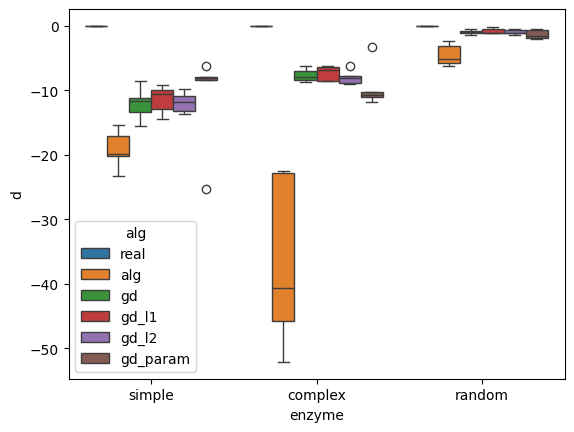

In [ ]:
import pandas as pd
import math

df = {"alg": [], "enzyme": [], "d": []}
for alg in bmrk.results.keys():
    if alg == "real":
        continue
    for enzyme_name in enzyme_names:
        for iteration in range(5):
            df["alg"].append(alg)
            df["enzyme"].append(enzyme_name)
            df["d"].append(
                math.abs(
                    bmrk.results["real"][enzyme_name][iteration]["d"]
                    - bmrk.results[alg][enzyme_name][iteration]["d"]
                )
            )
df = pd.DataFrame(df)
import seaborn as sns

sns.boxplot(df, x="enzyme", y="d", hue="alg")

# Peptidomes

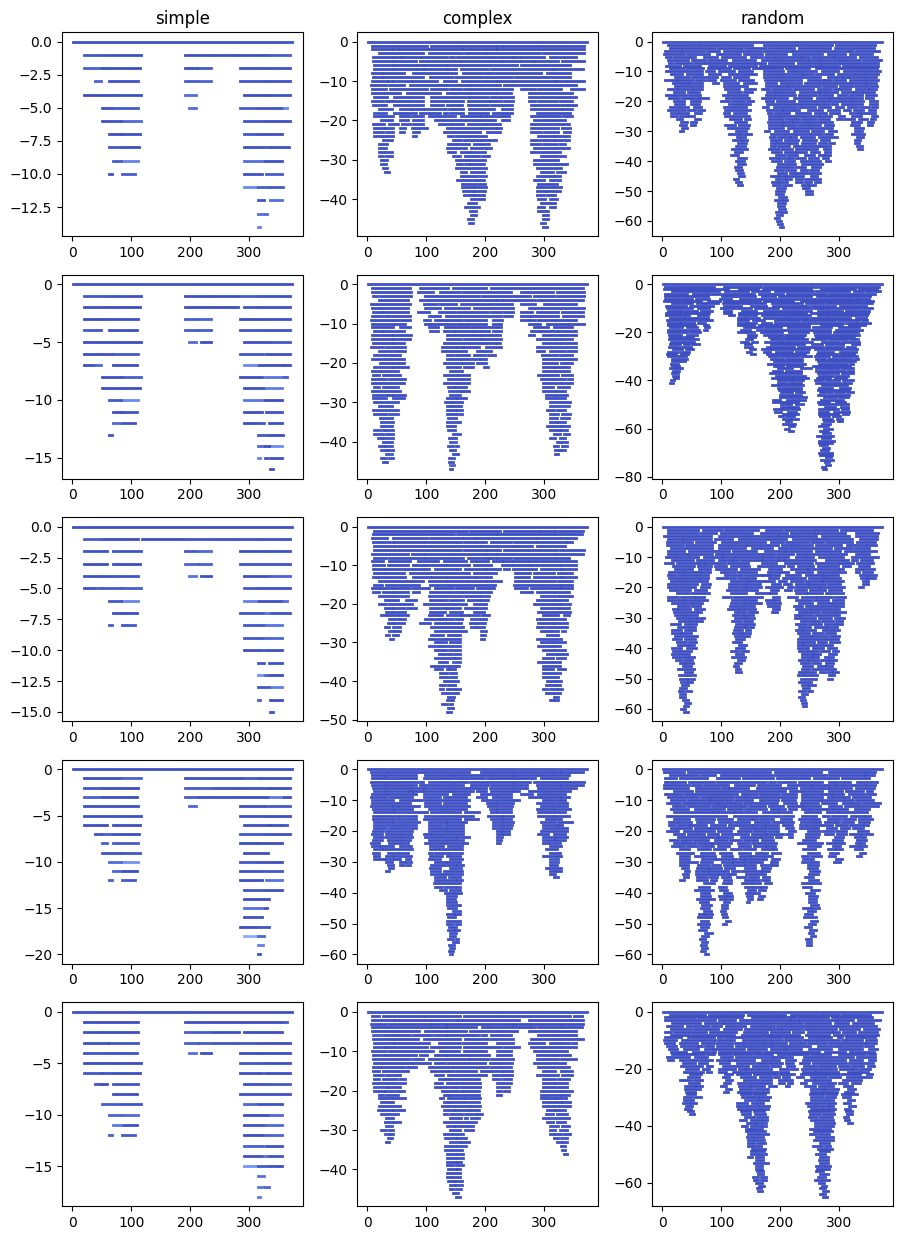

In [ ]:
from disassembly.util import plot_peptidome

fig, axs = plt.subplots(
    bmrk.iterations,
    len(bmrk.enzyme_names),
    figsize=(len(bmrk.enzyme_names) * 3, bmrk.iterations * 2.5),
)
for iteration in range(bmrk.iterations):
    for test_name in bmrk.enzyme_names:
        ax = axs[iteration, bmrk.enzyme_names.index(test_name)]
        if iteration == 0:
            ax.set_title(test_name)
        plot_peptidome(protein, bmrk.simulated_peptidomes[test_name][iteration], ax)
plt.tight_layout()